In [1]:
!pip install pandas

In [3]:
!pip install "numpy<2"

In [5]:
import pandas as pd
import numpy as np

In [7]:
import os
os.getcwd()

'C:\\Users\\jishu'

In [9]:
df= pd.read_csv("C:/Users/jishu/OneDrive/Ritu/Customer-Churn-Dataset.csv")
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
df = df.drop(columns=["CustomerID"])

In [13]:
print(df.columns.tolist())


['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [17]:
df = pd.read_csv("Telco_Customer_Cleaned.csv")

df.drop(columns=["CustomerID"], inplace=True)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Convert TotalCharges safely
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

# -----------------------------
# FEATURE ENGINEERING
# -----------------------------

# AvgMonthlySpend
df["AvgMonthlySpend"] = df.apply(
    lambda x: 0 if x["Tenure"] == 0 else x["TotalCharges"] / x["Tenure"],
    axis=1
)

# TenureCategory
tenure_bins = [0, 12, 24, 48, 72]
tenure_labels = ["0-12", "13-24", "25-48", "49-72"]
df["TenureCategory"] = pd.cut(df["Tenure"], bins=tenure_bins, labels=tenure_labels)

# ContractType
contract_map = {
    "Month-to-month": "ShortTerm",
    "One year": "MidTerm",
    "Two year": "LongTerm"
}
df["ContractType"] = df["Contract"].map(contract_map)

# -----------------------------
# BINARY COLUMNS
# -----------------------------
binary_cols = [
    "Partner","Dependents","PhoneService","PaperlessBilling",
    "OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies","MultipleLines"
]

df[binary_cols] = df[binary_cols].replace(
    {"Yes": 1, "No": 0, "No phone service": 0}
)

# -----------------------------
# ONE-HOT ENCODING
# -----------------------------
cat_cols = ["Gender", "InternetService", "PaymentMethod",
            "Contract", "ContractType", "TenureCategory"]

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# -----------------------------
# FINAL CLEANUP
# -----------------------------
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

print("Final shape:", df.shape)
df.head()


Final shape: (7043, 30)


C:\Users\jishu\AppData\Local\Temp\ipykernel_2200\2018174354.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace(


,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year,ContractType_MidTerm,ContractType_ShortTerm,TenureCategory_13-24,TenureCategory_25-48,TenureCategory_49-72
0,0,1,0,1,0,0,0,1,0,0,...,False,True,False,False,False,False,True,False,False,False
1,0,0,0,34,1,0,1,0,1,0,...,False,False,True,True,False,True,False,False,True,False
2,0,0,0,2,1,0,1,1,0,0,...,False,False,True,False,False,False,True,False,False,False
3,0,0,0,45,0,0,1,0,1,1,...,False,False,False,True,False,True,False,False,True,False
4,0,0,0,2,1,0,0,0,0,0,...,False,True,False,False,False,False,True,False,False,False


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

pipe = Pipeline([
    ("scaler", StandardScaler())
])

X_train_scaled = pipe.fit_transform(X_train)
X_test_scaled = pipe.transform(X_test)

print("NaN in scaled X_train:", np.isnan(X_train_scaled).any())



NaN in scaled X_train: False


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define models
model_list = [
    ("Logistic Regression", LogisticRegression(max_iter=500)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42))
]

metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1": f1_score,
    "AUC": roc_auc_score
}

rows = []

for name, model in model_list:
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    row = [name]

    # compute all metrics dynamically
    for m_name, func in metrics.items():
        if m_name == "AUC":
            row.append(func(y_test, y_prob))
        else:
            row.append(func(y_test, y_pred))

    rows.append(row)

results_df = pd.DataFrame(rows, columns=["Model"] + list(metrics.keys()))
results_df


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.797729,0.648829,0.518717,0.576523,0.842207
1,Decision Tree,0.731015,0.493506,0.508021,0.500659,0.659332
2,Random Forest,0.788502,0.629252,0.494652,0.553892,0.826611
3,Gradient Boosting,0.806955,0.677083,0.521390,0.589124,0.843875


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Base model
log_reg = LogisticRegression(max_iter=1000)

# Parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "class_weight": [None, "balanced"],
    "solver": ["lbfgs"]
}

# Grid Search setup
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search.fit(X_train_scaled, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

best_log_reg = grid_search.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV AUC: 0.846529231680426


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Base Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter distribution
param_dist = {
    "n_estimators": randint(200, 600),
    "max_depth": randint(4, 20),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["auto", "sqrt", "log2"]
}

# Randomized Search Setup
rand_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    scoring="roc_auc",
    n_iter=20,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train
rand_search.fit(X_train, y_train)

# Output
print("Best Random Forest Params:", rand_search.best_params_)
print("Best Cross-Val AUC:", rand_search.best_score_)

best_random_forest = rand_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\jishu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jishu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jishu\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\jishu\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\jishu\anaconda3\Lib\site-packages

Best Random Forest Params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 305}
Best Cross-Val AUC: 0.8457428011219816


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Base model
gb_model = GradientBoostingClassifier(random_state=42)

# Search space
param_space = {
    "n_estimators": randint(100, 400),
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": randint(2, 6),
    "subsample": [0.7, 0.85, 1.0]
}

# Randomized search setup
gb_random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_space,
    scoring="roc_auc",
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit model
gb_random_search.fit(X_train, y_train)

# Output best results
print("Best Gradient Boosting Parameters:", gb_random_search.best_params_)
print("Best Cross-Validation AUC:", gb_random_search.best_score_)

# Best model
optimized_gb = gb_random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 290, 'subsample': 0.85}
Best Cross-Validation AUC: 0.8477054439292401


In [35]:
# --- LOGISTIC REGRESSION ---
try:
    best_lr
except NameError:
    best_lr = LogisticRegression(max_iter=500)
    best_lr.fit(X_train_scaled, y_train)

# --- DECISION TREE ---
try:
    best_dt
except NameError:
    best_dt = DecisionTreeClassifier(random_state=42)
    best_dt.fit(X_train, y_train)

# --- RANDOM FOREST ---
try:
    best_rf
except NameError:
    best_rf = RandomForestClassifier(random_state=42)
    best_rf.fit(X_train, y_train)

# --- GRADIENT BOOSTING ---
try:
    best_gb
except NameError:
    best_gb = GradientBoostingClassifier(random_state=42)
    best_gb.fit(X_train, y_train)


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate(model, test_data):
    y_pred = model.predict(test_data)
    y_proba = model.predict_proba(test_data)[:, 1]
    return [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_proba)
    ]

models = {
    "Logistic Regression": (best_lr, X_test_scaled),
    "Decision Tree": (best_dt, X_test),
    "Random Forest": (best_rf, X_test),
    "Gradient Boosting": (best_gb, X_test)
}

results = []
for name, (model, test_data) in models.items():
    results.append([name] + evaluate(model, test_data))

eval_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC ROC"]
)

print(eval_df)


                 Model  Accuracy  Precision    Recall  F1 Score   AUC ROC
0  Logistic Regression  0.797729   0.648829  0.518717  0.576523  0.842207
1        Decision Tree  0.731725   0.494819  0.510695  0.502632  0.660672
2        Random Forest  0.788502   0.629252  0.494652  0.553892  0.826978
3    Gradient Boosting  0.806955   0.677083  0.521390  0.589124  0.843976



Top 5 Features — Decision Tree
ContractType_ShortTerm    0.166082
TotalCharges              0.144684
AvgMonthlySpend           0.141181
MonthlyCharges            0.140992
Tenure                    0.108472
dtype: float64


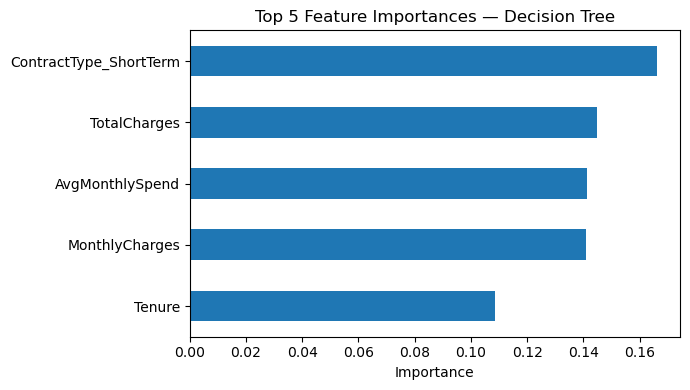


Top 5 Features — Random Forest
TotalCharges              0.146628
AvgMonthlySpend           0.136670
MonthlyCharges            0.134603
Tenure                    0.130612
ContractType_ShortTerm    0.058955
dtype: float64


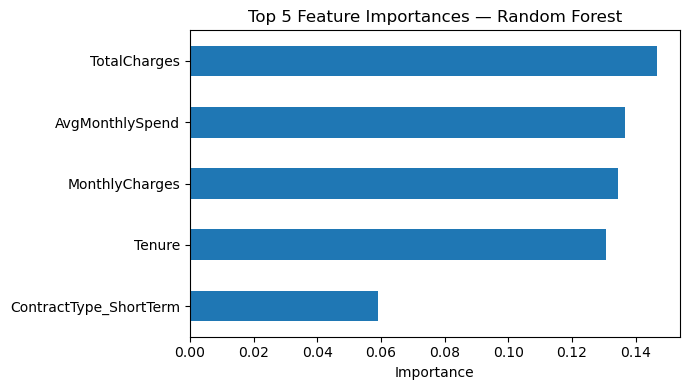


Top 5 Features — Gradient Boosting
ContractType_ShortTerm            0.407464
Tenure                            0.142993
InternetService_Fiber optic       0.110856
TotalCharges                      0.070795
PaymentMethod_Electronic check    0.056768
dtype: float64


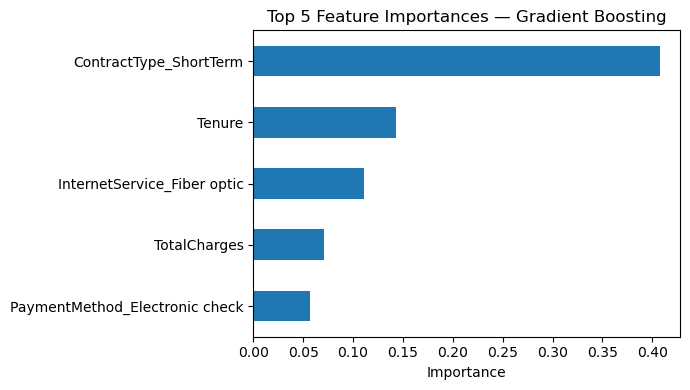

In [39]:
import matplotlib.pyplot as plt

tree_models = {
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb
}

def plot_top_features(model, name, features, top_n=5):
    """Helper function for top N feature importance"""
    fi = pd.Series(model.feature_importances_, index=features)
    fi = fi.sort_values(ascending=False).head(top_n)

    # Print table
    print(f"\nTop {top_n} Features — {name}")
    print(fi)

    # Plot
    plt.figure(figsize=(7,4))
    fi.iloc[::-1].plot(kind="barh")
    plt.title(f"Top {top_n} Feature Importances — {name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# Loop through models
for name, model in tree_models.items():
    plot_top_features(model, name, X.columns)
